# Examples from manuscript

Code to run the examples reported at https://arxiv.org/abs/2009.01077

In [1]:
import sys
sys.path.append('/Users/landii03/Projects/reval_clustering/')

from sklearn.datasets import make_blobs, load_digits
from sklearn.model_selection import train_test_split
from reval.best_nclust_cv import FindBestClustCV
from reval.internal_baselines import select_best, evaluate_best

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.metrics import zero_one_loss, adjusted_mutual_info_score, silhouette_score, davies_bouldin_score
from reval.visualization import plot_metrics
import matplotlib.pyplot as plt
from reval.utils import kuhn_munkres_algorithm, compute_metrics
from umap import UMAP
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from datasets.manuscript_builddatasets import build_ucidatasets
import numpy as np
import warnings
import time
import pandas as pd

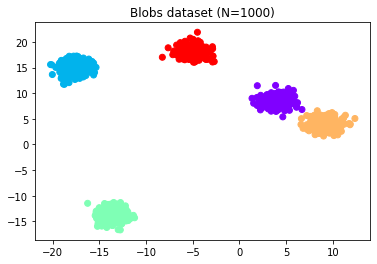

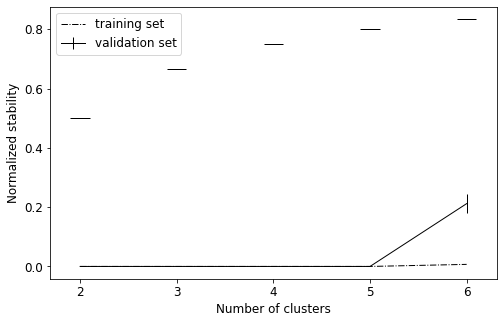

ACC 1.0
MCC 1.0
F1 1.0
precision 1.0
recall 1.0
Best number of clusters: 5
AMI (true labels vs predicted labels) = 1.0
Silhouette score based selection
Best number of clusters (and scores) for tr/ts independent runs: 5(0.829986284785402)/5(0.8318685705425193)
Test set evaluation 0.8318685705425193
Davies-Bouldin score based selection
Best number of clusters (and scores) for tr/ts independent runs: 4(0.23188705176665572)/5(0.23332007909711142)
Test set evaluation 0.238345242770787


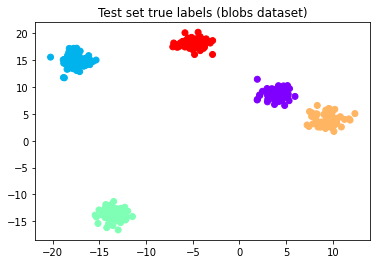

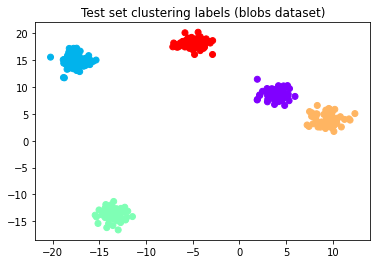

In [2]:
"""
Three example functions that can alse be run from shell (see manuscript_examples.py file). 

Example 1: blobs dataset;
Example 2: real-world dataset (handwritten digits)
Example 3: ensamble learning with 18 datasets from UCI Machine Learning Repository.
           Algorithm performances are saved to manuscript_example.log file.
"""
# import cProfile, pstats, io
# from pstats import SortKey
# pr = cProfile.Profile()
# pr.enable()

# EXAMPLE 1: Isotropic Gaussian blobs
data = make_blobs(1000, 2, centers=5, center_box=(-20, 20),
                  random_state=42)
plt.figure(figsize=(6, 4))
plt.scatter(data[0][:, 0],
            data[0][:, 1],
            c=data[1], cmap='rainbow_r')
plt.title("Blobs dataset (N=1000)")
plt.show()

X_tr, X_ts, y_tr, y_ts = train_test_split(data[0],
                                          data[1],
                                          test_size=0.30,
                                          random_state=42,
                                          stratify=data[1])

classifier = KNeighborsClassifier(n_neighbors=15)
clustering = KMeans()

findbestclust = FindBestClustCV(nfold=2,
                                nclust_range=list(range(2, 7, 1)),
                                s=classifier,
                                c=clustering,
                                nrand=10,
                                n_jobs=7)
metrics, nbest = findbestclust.best_nclust(X_tr, iter_cv=10, strat_vect=y_tr)
out = findbestclust.evaluate(X_tr, X_ts, nbest)

plot_metrics(metrics)
perm_lab = kuhn_munkres_algorithm(y_ts, out.test_cllab)

# Compute metrics
class_scores = compute_metrics(y_ts, perm_lab, perm=False)

for k, val in class_scores.items():
    print(k, val)

print(f"Best number of clusters: {nbest}")
print(f'AMI (true labels vs predicted labels) = '
      f'{adjusted_mutual_info_score(y_ts, out.test_cllab)}')

print("Silhouette score based selection")
sil_score_tr, sil_best_tr = select_best(X_tr, clustering, silhouette_score, nclust_range=list(range(2, 7, 1)))
sil_score_ts, sil_best_ts = select_best(X_ts, clustering, silhouette_score, nclust_range=list(range(2, 7, 1)))

sil_eval = evaluate_best(X_ts, clustering, silhouette_score, sil_best_tr)

print(f"Best number of clusters (and scores) for tr/ts independent runs: {sil_best_tr}({sil_score_tr})/{sil_best_ts}({sil_score_ts})")
print(f"Test set evaluation {sil_eval}")

print("Davies-Bouldin score based selection")
db_score_tr, db_best_tr = select_best(X_tr, clustering, davies_bouldin_score, 
                                        select='min', nclust_range=list(range(2, 7, 1)))
db_score_ts, db_best_ts = select_best(X_ts, clustering, davies_bouldin_score, 
                                        select='min', nclust_range=list(range(2, 7, 1)))

db_eval = evaluate_best(X_ts, clustering, davies_bouldin_score, db_best_tr)

print(f"Best number of clusters (and scores) for tr/ts independent runs: {db_best_tr}({db_score_tr})/{db_best_ts}({db_score_ts})")
print(f"Test set evaluation {db_eval}")

plt.figure(figsize=(6, 4))
plt.scatter(X_ts[:, 0], X_ts[:, 1],
            c=y_ts, cmap='rainbow_r')
plt.title("Test set true labels (blobs dataset)")
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(X_ts[:, 0], X_ts[:, 1],
            c=perm_lab, cmap='rainbow_r')
plt.title("Test set clustering labels (blobs dataset)")
plt.show()

# pr.disable()
# s = io.StringIO()
# sortby = SortKey.CUMULATIVE
# ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())

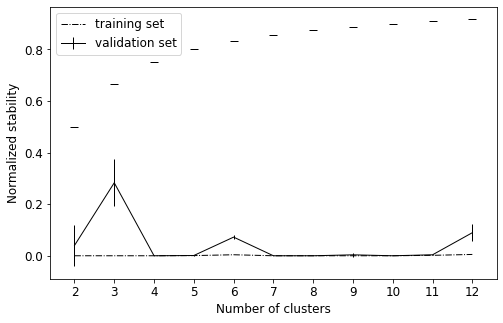

ACC 0.8720445062586927
MCC 0.8619474682197507
F1 0.8591190835679623
precision 0.87533328327
recall 0.8730491089612255
Best number of clusters: 10
AMI (true labels vs predicted labels) = 0.8567749881123198
Silhouette score based selection
Best number of clusters (and scores) for tr/ts independent runs: 6(0.6862215399742126)/6(0.6727235913276672)
Test set evaluation 0.6727235913276672
Davies-Bouldin score based selection
Best number of clusters (and scores) for tr/ts independent runs: 3(0.3152039617849003)/2(0.3464706669679047)
Test set evaluation 0.5940686736554045


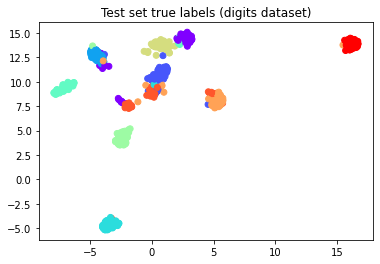

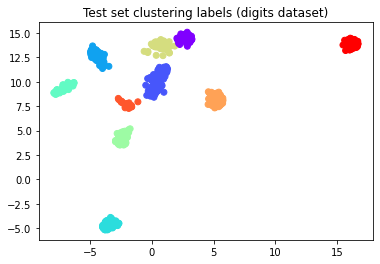

In [4]:
# import cProfile, pstats, io
# from pstats import SortKey
# pr = cProfile.Profile()
# pr.enable()

# EXAMPLE 2: UCI handwritten digits dataset example
# start = time.time()
digits_dataset = load_digits()

digits_data = digits_dataset['data']
digits_target = digits_dataset['target']

X_tr, X_ts, y_tr, y_ts = train_test_split(digits_data,
                                          digits_target,
                                          test_size=0.40,
                                          random_state=42,
                                          stratify=digits_target)

transform = UMAP(n_components=2,
                 random_state=42,
                 n_neighbors=30,
                 min_dist=0.0)
X_tr = transform.fit_transform(X_tr)
X_ts = transform.transform(X_ts)

s = KNeighborsClassifier(n_neighbors=30)
c = KMeans()

reval = FindBestClustCV(s=s,
                        c=c,
                        nfold=2,
                        nclust_range=list(range(2, 13)),
                        nrand=10,
                        n_jobs=7)

metrics, nclustbest = reval.best_nclust(X_tr, iter_cv=10, strat_vect=y_tr)

plot_metrics(metrics)

out = reval.evaluate(X_tr, X_ts, nclust=nclustbest)
perm_lab = kuhn_munkres_algorithm(y_ts, out.test_cllab)

class_scores = compute_metrics(y_ts, perm_lab)

for k, val in class_scores.items():
    print(k, val)

print(f"Best number of clusters: {nclustbest}")
print(f'AMI (true labels vs predicted labels) = '
      f'{adjusted_mutual_info_score(y_ts, out.test_cllab)}')

print("Silhouette score based selection")
sil_score_tr, sil_best_tr = select_best(X_tr, c, silhouette_score, nclust_range=list(range(2, 7, 1)))
sil_score_ts, sil_best_ts = select_best(X_ts, c, silhouette_score, nclust_range=list(range(2, 7, 1)))

sil_eval = evaluate_best(X_ts, c, silhouette_score, sil_best_tr)

print(f"Best number of clusters (and scores) for tr/ts independent runs: {sil_best_tr}({sil_score_tr})/{sil_best_ts}({sil_score_ts})")
print(f"Test set evaluation {sil_eval}")

print("Davies-Bouldin score based selection")
db_score_tr, db_best_tr = select_best(X_tr, c, davies_bouldin_score, 
                                        select='min', nclust_range=list(range(2, 7, 1)))
db_score_ts, db_best_ts = select_best(X_ts, c, davies_bouldin_score, 
                                        select='min', nclust_range=list(range(2, 7, 1)))

db_eval = evaluate_best(X_ts, c, davies_bouldin_score, db_best_tr)

print(f"Best number of clusters (and scores) for tr/ts independent runs: {db_best_tr}({db_score_tr})/{db_best_ts}({db_score_ts})")
print(f"Test set evaluation {db_eval}")

plt.figure(figsize=(6, 4))
plt.scatter(X_ts[:, 0],
            X_ts[:, 1],
            c=y_ts, cmap='rainbow_r')
plt.title("Test set true labels (digits dataset)")
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(X_ts[:, 0],
            X_ts[:, 1],
            c=perm_lab, cmap='rainbow_r')
plt.title("Test set clustering labels (digits dataset)")
plt.show()

# pr.disable()
# s = io.StringIO()
# sortby = SortKey.CUMULATIVE
# ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())

## MNIST real-world dataset

In [5]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(int)
from reval.param_selection import ParamSelection

In [6]:
X_tr, y_tr = mnist['data'][:60000], mnist.target[:60000]
X_ts, y_ts = mnist['data'][60000::], mnist.target[60000::]

In [ ]:
# transform = UMAP(n_components=2,
#                  random_state=42,
#                  n_neighbors=10,
#                  min_dist=0.0)
# X_tr = transform.fit_transform(X_tr)
# X_ts = transform.transform(X_ts)

s = KNeighborsClassifier(n_neighbors = 30)
c = KMeans()

# ps = ParamSelection({'s': {'n_neighbors': [5, 10, 15, 50]},
#                      'c': {}}, 
#                        cv=2,
#                        s=s,
#                        c=c,
#                        nrand=10, 
#                        clust_range=list(range(2, 13)),
#                        n_jobs=7,
#                        strat=y_tr)

# ps.fit(X_tr, 10)

reval = FindBestClustCV(s=s,
                        c=c,
                        nfold=2,
                        nclust_range=list(range(2, 13)),
                        nrand=10,
                        n_jobs=7)

metrics, nclustbest = reval.best_nclust(X_tr, iter_cv=10, strat_vect=y_tr)

plot_metrics(metrics)

out = reval.evaluate(X_tr, X_ts, nclust=nclustbest)
perm_lab = kuhn_munkres_algorithm(y_ts, out.test_cllab)

class_scores = compute_metrics(y_ts, perm_lab)

for k, val in class_scores.items():
    print(k, val)

print(f"Best number of clusters: {nclustbest}")
print(f'AMI (true labels vs predicted labels) = '
      f'{adjusted_mutual_info_score(y_ts, out.test_cllab)}')

# print(f"Silhouette (tr/ts): {silhouette_score(X_tr, out.train_cllab)}/{silhouette_score(X_ts, out.test_cllab)}")
# print(f"Davies-Bouldin score (tr/ts): {davies_bouldin_score(X_tr, out.train_cllab)}/{davies_bouldin_score(X_ts, out.test_cllab)}")
print("Silhouette score based selection")
sil_score_tr, sil_best_tr = select_best(X_tr, c, silhouette_score, nclust_range=list(range(2, 13, 1)))
sil_score_ts, sil_best_ts = select_best(X_ts, c, silhouette_score, nclust_range=list(range(2, 13, 1)))

sil_eval = evaluate_best(X_ts, c, silhouette_score, sil_best_tr)

print(f"Best number of clusters (and scores) for tr/ts independent runs: {sil_best_tr}({sil_score_tr})/{sil_best_ts}({sil_score_ts})")
print(f"Test set evaluation {sil_eval}")

print("Davies-Bouldin score based selection")
db_score_tr, db_best_tr = select_best(X_tr, c, davies_bouldin_score, 
                                        select='min', nclust_range=list(range(2, 13, 1)))
db_score_ts, db_best_ts = select_best(X_ts, c, davies_bouldin_score, 
                                        select='min', nclust_range=list(range(2, 13, 1)))

db_eval = evaluate_best(X_ts, c, davies_bouldin_score, db_best_tr)

print(f"Best number of clusters (and scores) for tr/ts independent runs: {db_best_tr}({db_score_tr})/{db_best_ts}({db_score_ts})")
print(f"Test set evaluation {db_eval}")


plt.figure(figsize=(6, 4))
plt.scatter(X_tr[:, 0],
            X_tr[:, 1],
            c=y_tr, cmap='rainbow_r',
            s=0.1)
plt.title("Train set true labels (digits dataset)")
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(X_ts[:, 0],
            X_ts[:, 1],
            c=y_ts, cmap='rainbow_r',
            s=0.1)
plt.title("Test set true labels (digits dataset)")
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(X_ts[:, 0],
            X_ts[:, 1],
            s=0.1,
            c=perm_lab, cmap='rainbow_r')
plt.title("Test set clustering labels (digits dataset)")
plt.show()

In [ ]:
# Example 3: ensemble learning
# Classifiers
knn = KNeighborsClassifier(n_neighbors=1,
                           metric='euclidean')
rf = RandomForestClassifier(n_estimators=100,
                            random_state=42)
svm = SVC(C=1,
          random_state=42)
logreg = LogisticRegression(solver='liblinear',
                            random_state=42)

classifiers = [knn, logreg, svm, rf]

# Clustering
hc = AgglomerativeClustering()
km = KMeans(random_state=42)
sc = SpectralClustering(random_state=42)

clustering = [hc, km, sc]

# scaler = StandardScaler()
transform = UMAP(n_neighbors=30, min_dist=0.0, random_state=42)

# Import benchmark datasets
uci_data = build_ucidatasets()
# Run ensemble learning algorithm
for data, name in zip(uci_data, uci_data._fields):
    nclass = len(np.unique(data['target']))
    logging.info(f"Processing dataset {name}")
    logging.info(f"Number of classes: {nclass}\n")
    X_tr, X_ts, y_tr, y_ts = train_test_split(data['data'],
                                              data['target'],
                                              test_size=0.40,
                                              random_state=42,
                                              stratify=data['target'])
    X_tr = transform.fit_transform(X_tr)
    X_ts = transform.transform(X_ts)
    for s in classifiers:
        if type(s) == type(svm):
            svm.gamma = 1 / data['data'].shape[0]
        for c in clustering:
            logging.info(f"Clustering algorithm: {c} -- Classification algorithm {s}")
            reval = FindBestClustCV(s=s,
                                    c=c,
                                    nfold=5,
                                    nclust_range=[2, nclass + 3],
                                    nrand=100,
                                    n_jobs=7)
            metrics, nclustbest, _ = reval.best_nclust(X_tr, strat_vect=y_tr)

            out = reval.evaluate(X_tr, X_ts, nclust=nclustbest)
            perm_lab = kuhn_munkres_algorithm(y_ts, out.test_cllab)

            logging.info(f"Best number of clusters: {nclustbest}")
            logging.info(f"Test set prediction ACC: "
                         f"{1 - zero_one_loss(y_ts, perm_lab)}")
            logging.info(f'AMI (true labels vs predicted labels) = '
                         f'{adjusted_mutual_info_score(y_ts, out.test_cllab)}')
            logging.info(f"Validation set normalized stability (misclassification):"
                         f"{metrics['val'][nclustbest]}")
            logging.info(f'Test set ACC = {out.test_acc} '
                         f'(true labels vs predicted labels)\n')
    logging.info('*' * 100)
    logging.info('\n\n')

In [ ]:
[tuple([1,2,3] + [i]) for i in range(10)]